# Proyecto Final - Modelo de Riesgo Crediticio
## Redes Neuronales y Máquinas de Soporte Vectorial
## Profesor: Dr. Román Rodríguez Aguilar
## Alumno: Lic. André Marx Puente Arévalo

## Librerías

In [1]:
# General
import pandas as pd
import numpy as np
import time

# Dibujos
import plotly.figure_factory as ff
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

#Estadística
from scipy.stats import kruskal

# ML
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix, f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.svm import SVC

# Opciones en pandas
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)

## Carga de Datos

In [2]:
df = pd.read_csv('tad.csv', encoding = 'latin')

## Funciones

In [3]:
def metricas(y_p,y_r): #Mide efectividad de un Modelo Predictivo
    print( " F1 Score: %.3f" %f1_score(y_pred=y_p, y_true=y_r))
    print( " Roc Validate: %.3f" %roc_auc_score(y_score=y_p,y_true=y_r))
    print( " Acc Validate: %.3f" %accuracy_score(y_pred=y_p,y_true=y_r))
    print( " Matrix Conf Validate: ", "\n",confusion_matrix(y_pred=y_p,y_true=y_r))

## Análisis Exploratorio de Datos

In [4]:
# Se validan Duplicados
n = df.shape[0]
print(f'Registros Originales: {format(n,",")}')
n2 = df.drop_duplicates('id_cliente').shape[0]
print(f'Registros Duplicados: {format(n-n2, ",")}')

Registros Originales: 130
Registros Duplicados: 0


In [5]:
# Completitud
aux = pd.DataFrame(df.isnull().sum()/df.shape[0])
aux[aux[0] >0]

0
blackliststatus_value          1.00
intercompanytransactions_value 0.24
customerconcentration_value    0.01
accountinginsolvency_value     0.32
canceledissuedinvoices_value   0.01

In [6]:
# Se eliminan variables que tienen muchos valores nulos
df.drop(columns = ['blackliststatus_value', 'intercompanytransactions_value', 'accountinginsolvency_value'], inplace = True)

# Imputo valores con la media
for col in ['customerconcentration_value', 'canceledissuedinvoices_value']:
    media = df[col].mean()
    df[col].fillna(media, inplace = True)
    
aux = pd.DataFrame(df.isnull().sum()/df.shape[0])
aux

0
id_cliente                      0.00
par30                           0.00
tasa_crecimiento                0.00
margen_utilidad                 0.00
margen_cashflow                 0.00
variabilidad_ingresos           0.00
antiguedad                      0.00
concentracion_clientes          0.00
concentracion_proveedores       0.00
factor_perdida_clientes         0.00
taxcompliance_value             0.00
blacklistedcounterparties_value 0.00
customerconcentration_value     0.00
supplierconcentration_value     0.00
foreignexchangerisk_value       0.00
cashtransactionrisk_value       0.00
canceledissuedinvoices_value    0.00
canceledreceivedinvoices_value  0.00
Kruskal_ley_benford             0.00
kolmogorov_ley_benford          0.00

In [7]:
# Se identifican las variables cuantitativas y cualitativas
vc = ['tasa_crecimiento', 'margen_utilidad',
       'margen_cashflow', 'variabilidad_ingresos', 'antiguedad',
       'concentracion_clientes', 'concentracion_proveedores',
       'factor_perdida_clientes', 'blacklistedcounterparties_value',
       'customerconcentration_value', 'supplierconcentration_value',
       'foreignexchangerisk_value', 'cashtransactionrisk_value',
       'canceledissuedinvoices_value', 'canceledreceivedinvoices_value',
       'Kruskal_ley_benford', 'kolmogorov_ley_benford']
vv = ['taxcompliance_value']

print(f'Número de Variables Cuantitativas: {len(vc)}')
print(f'Número de Variables Cualitativas: {len(vv)}')

Número de Variables Cuantitativas: 17
Número de Variables Cualitativas: 1


- **Continuas**

In [8]:
df[vc].describe(percentiles = [.01,.25,.5,.75,.99])

tasa_crecimiento  margen_utilidad  margen_cashflow  \
count            130.00           130.00           130.00   
mean               7.46            -5.90            -6.63   
std               10.35           129.92            98.82   
min              -16.42        -1,133.98          -859.90   
1%               -11.85          -608.62          -268.59   
25%                1.34            -7.79           -14.94   
50%                4.38             5.39             1.06   
75%               10.44            26.48            33.75   
99%               39.25            95.62            96.45   
max               48.11            96.78            97.93   

       variabilidad_ingresos  antiguedad  concentracion_clientes  \
count                 130.00      130.00                  130.00   
mean                   79.27       73.92                   47.29   
std                    51.80       33.07                   30.49   
min                     0.00        9.00                    0.00   
1%                     14.61       14.16                    0.01   
25%                    50.06       44.25                   21.00   
50%                    70.37       68.50                   44.66   
75%                    96.41      111.00                   73.13   
99%                   225.45      111.00                  100.00   
max                   397.89      111.00                  100.00   

       concentracion_proveedores  factor_perdida_clientes  \
count                     130.00                   130.00   
mean                       51.97                    54.02   
std                        21.63                    21.64   
min                         0.00                     0.00   
1%                         17.42                    14.11   
25%                        35.38                    39.64   
50%                        48.27                    53.24   
75%                        65.28                    68.36   
99%                        97.55                   100.00   
max                        99.77                   100.00   

       blacklistedcounterparties_value  customerconcentration_value  \
count                           130.00                       130.00   
mean                              0.02                     3,398.43   
std                               0.12                     2,853.70   
min                               0.00                         2.00   
1%                                0.00                       204.90   
25%                               0.00                     1,146.75   
50%                               0.00                     2,478.00   
75%                               0.00                     5,024.75   
99%                               0.71                     9,998.84   
max                               1.00                    10,000.00   

       supplierconcentration_value  foreignexchangerisk_value  \
count                       130.00                     130.00   
mean                      1,790.78                       0.01   
std                       1,526.11                       0.07   
min                         249.00                       0.00   
1%                          382.74                       0.00   
25%                         782.00                       0.00   
50%                       1,156.50                       0.00   
75%                       2,445.00                       0.00   
99%                       7,175.25                       0.25   
max                       7,966.00                       0.73   

       cashtransactionrisk_value  canceledissuedinvoices_value  \
count                     130.00                        130.00   
mean                        0.17                          0.06   
std                         0.17                          0.09   
min                         0.00                          0.00   
1%                          0.00                          0.00   
25%                 

array([[<AxesSubplot:title={'center':'tasa_crecimiento'}>,
        <AxesSubplot:title={'center':'margen_utilidad'}>,
        <AxesSubplot:title={'center':'margen_cashflow'}>,
        <AxesSubplot:title={'center':'variabilidad_ingresos'}>],
       [<AxesSubplot:title={'center':'antiguedad'}>,
        <AxesSubplot:title={'center':'concentracion_clientes'}>,
        <AxesSubplot:title={'center':'concentracion_proveedores'}>,
        <AxesSubplot:title={'center':'factor_perdida_clientes'}>],
       [<AxesSubplot:title={'center':'blacklistedcounterparties_value'}>,
        <AxesSubplot:title={'center':'customerconcentration_value'}>,
        <AxesSubplot:title={'center':'supplierconcentration_value'}>,
        <AxesSubplot:title={'center':'foreignexchangerisk_value'}>],
       [<AxesSubplot:title={'center':'cashtransactionrisk_value'}>,
        <AxesSubplot:title={'center':'canceledissuedinvoices_value'}>,
        <AxesSubplot:title={'center':'canceledreceivedinvoices_value'}>,
        <Axe

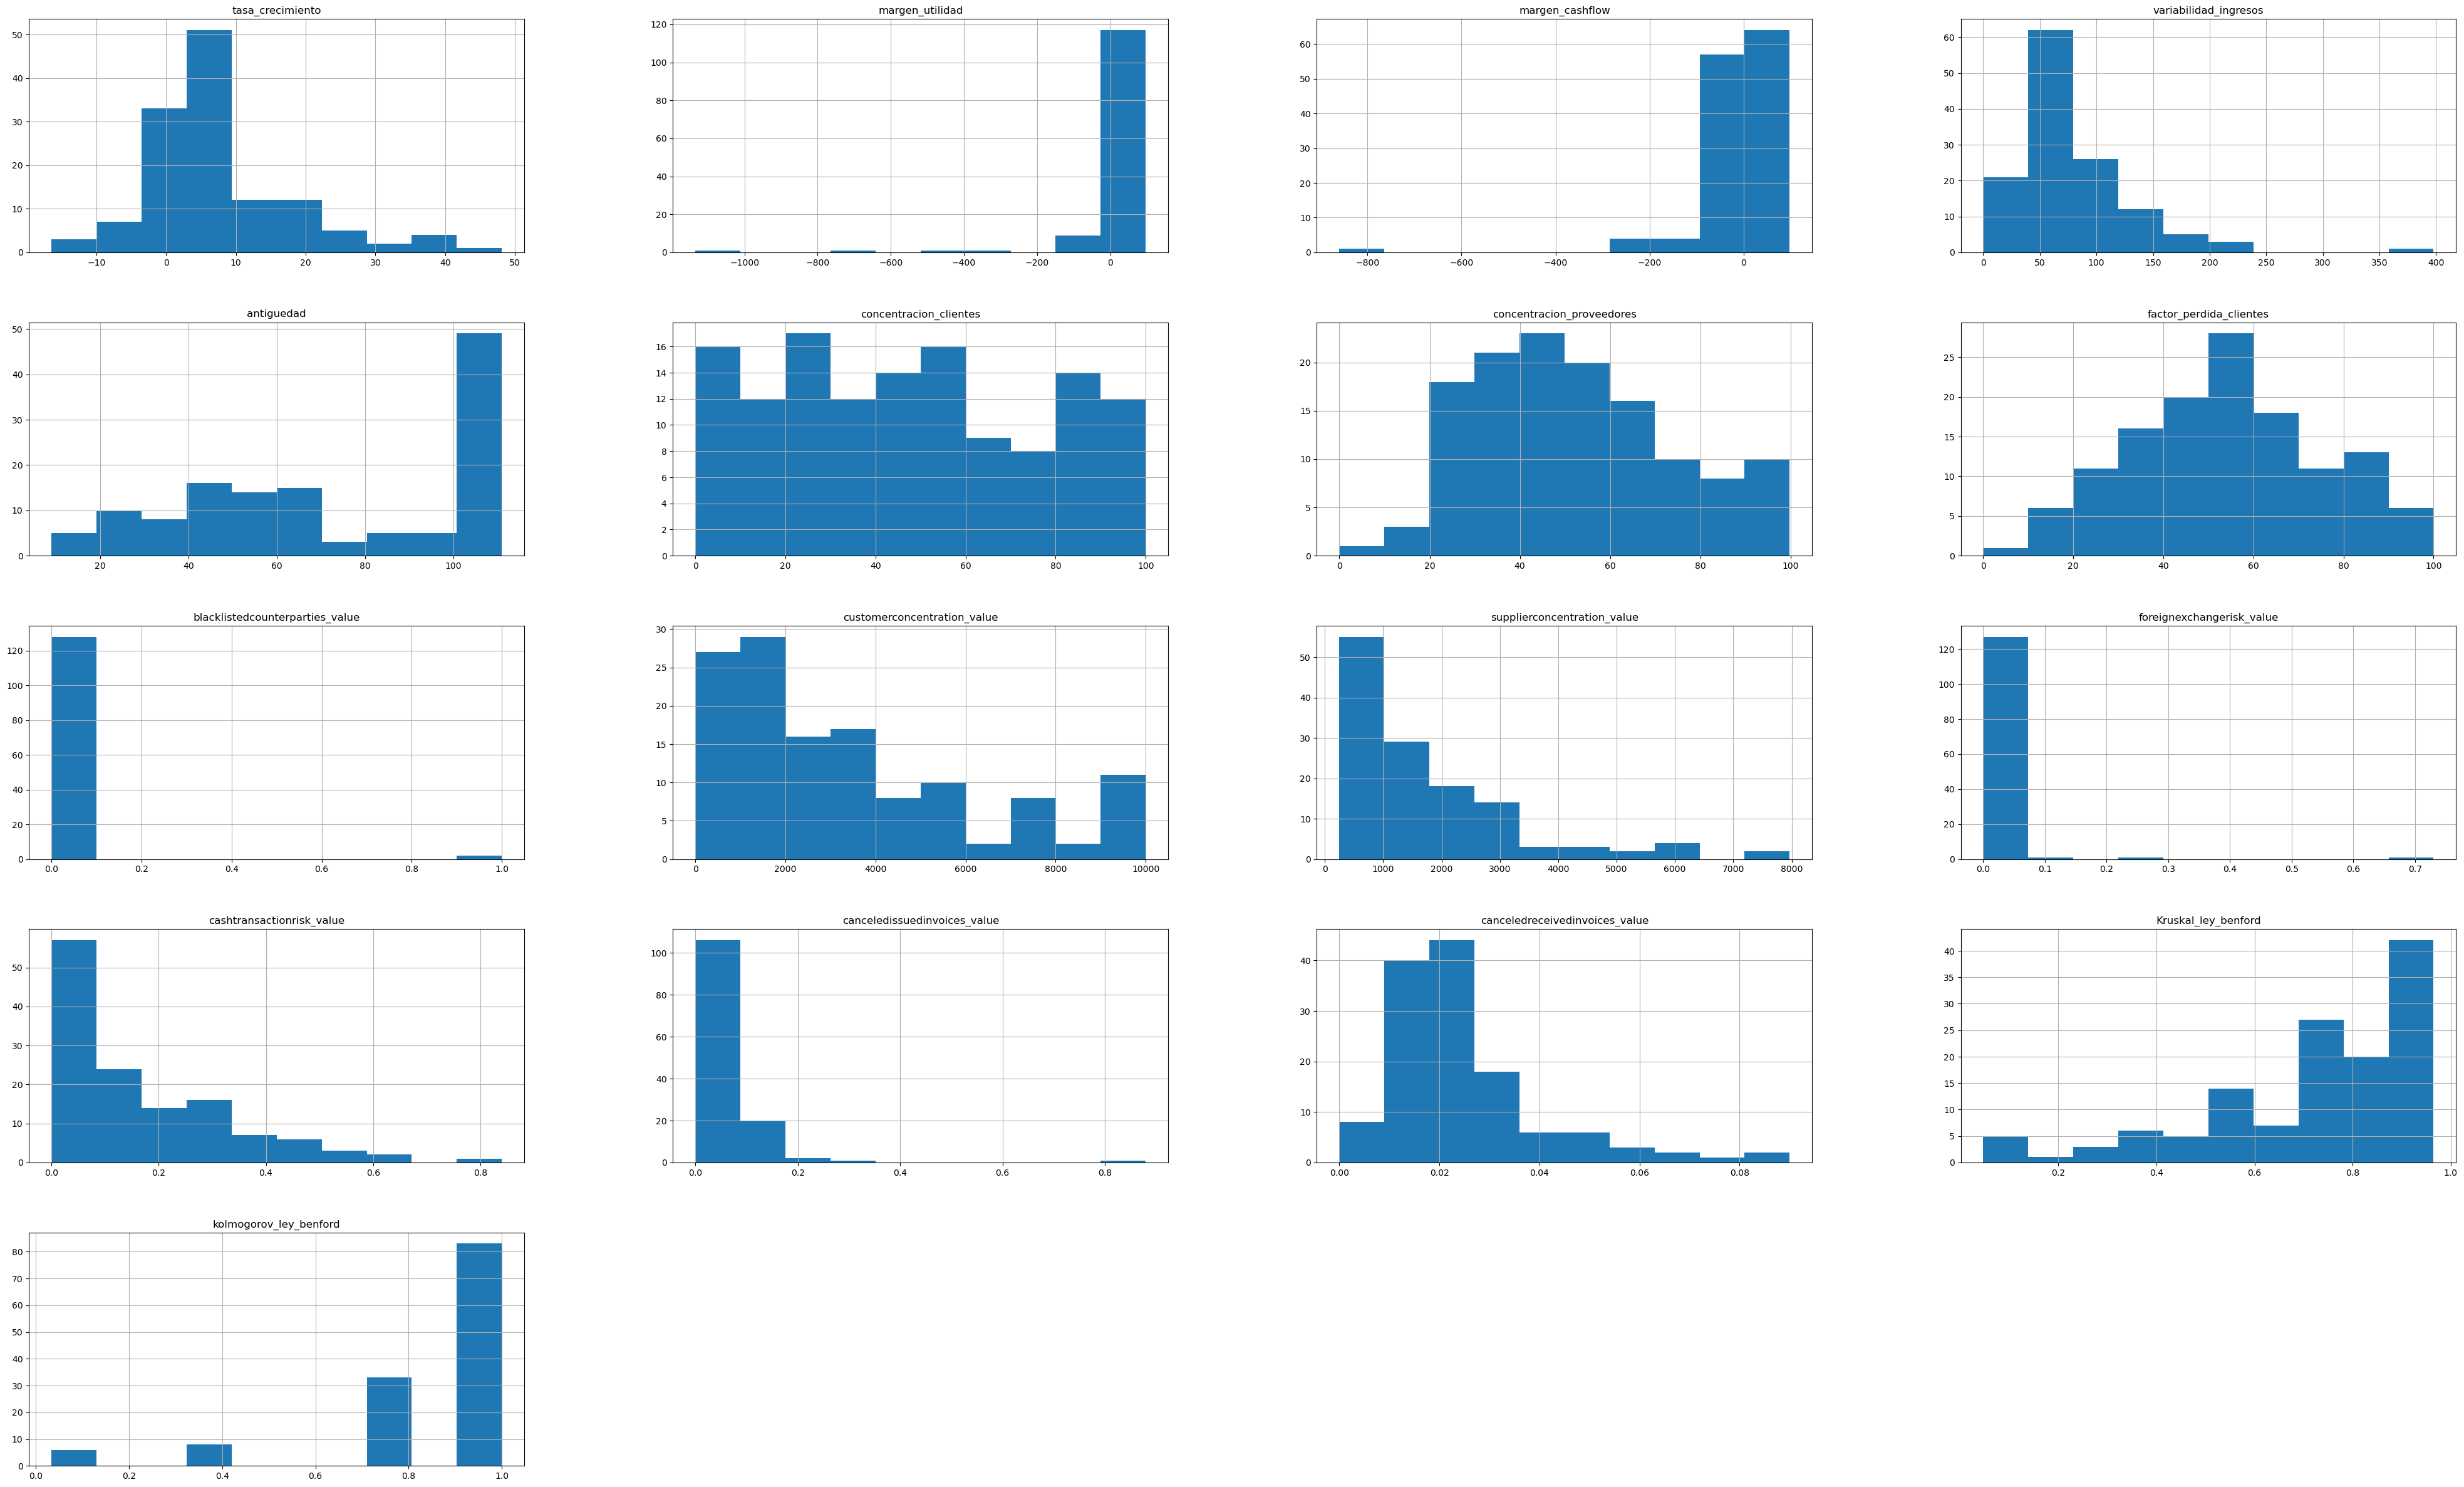

In [9]:
df[vc].hist(figsize = (50,30))

array([[<AxesSubplot:title={'center':'tasa_crecimiento'}>,
        <AxesSubplot:title={'center':'margen_utilidad'}>,
        <AxesSubplot:title={'center':'margen_cashflow'}>,
        <AxesSubplot:title={'center':'variabilidad_ingresos'}>],
       [<AxesSubplot:title={'center':'antiguedad'}>,
        <AxesSubplot:title={'center':'concentracion_clientes'}>,
        <AxesSubplot:title={'center':'concentracion_proveedores'}>,
        <AxesSubplot:title={'center':'factor_perdida_clientes'}>],
       [<AxesSubplot:title={'center':'customerconcentration_value'}>,
        <AxesSubplot:title={'center':'supplierconcentration_value'}>,
        <AxesSubplot:title={'center':'cashtransactionrisk_value'}>,
        <AxesSubplot:title={'center':'canceledissuedinvoices_value'}>],
       [<AxesSubplot:title={'center':'canceledreceivedinvoices_value'}>,
        <AxesSubplot:title={'center':'Kruskal_ley_benford'}>,
        <AxesSubplot:title={'center':'kolmogorov_ley_benford'}>,
        <AxesSubplot:>]], d

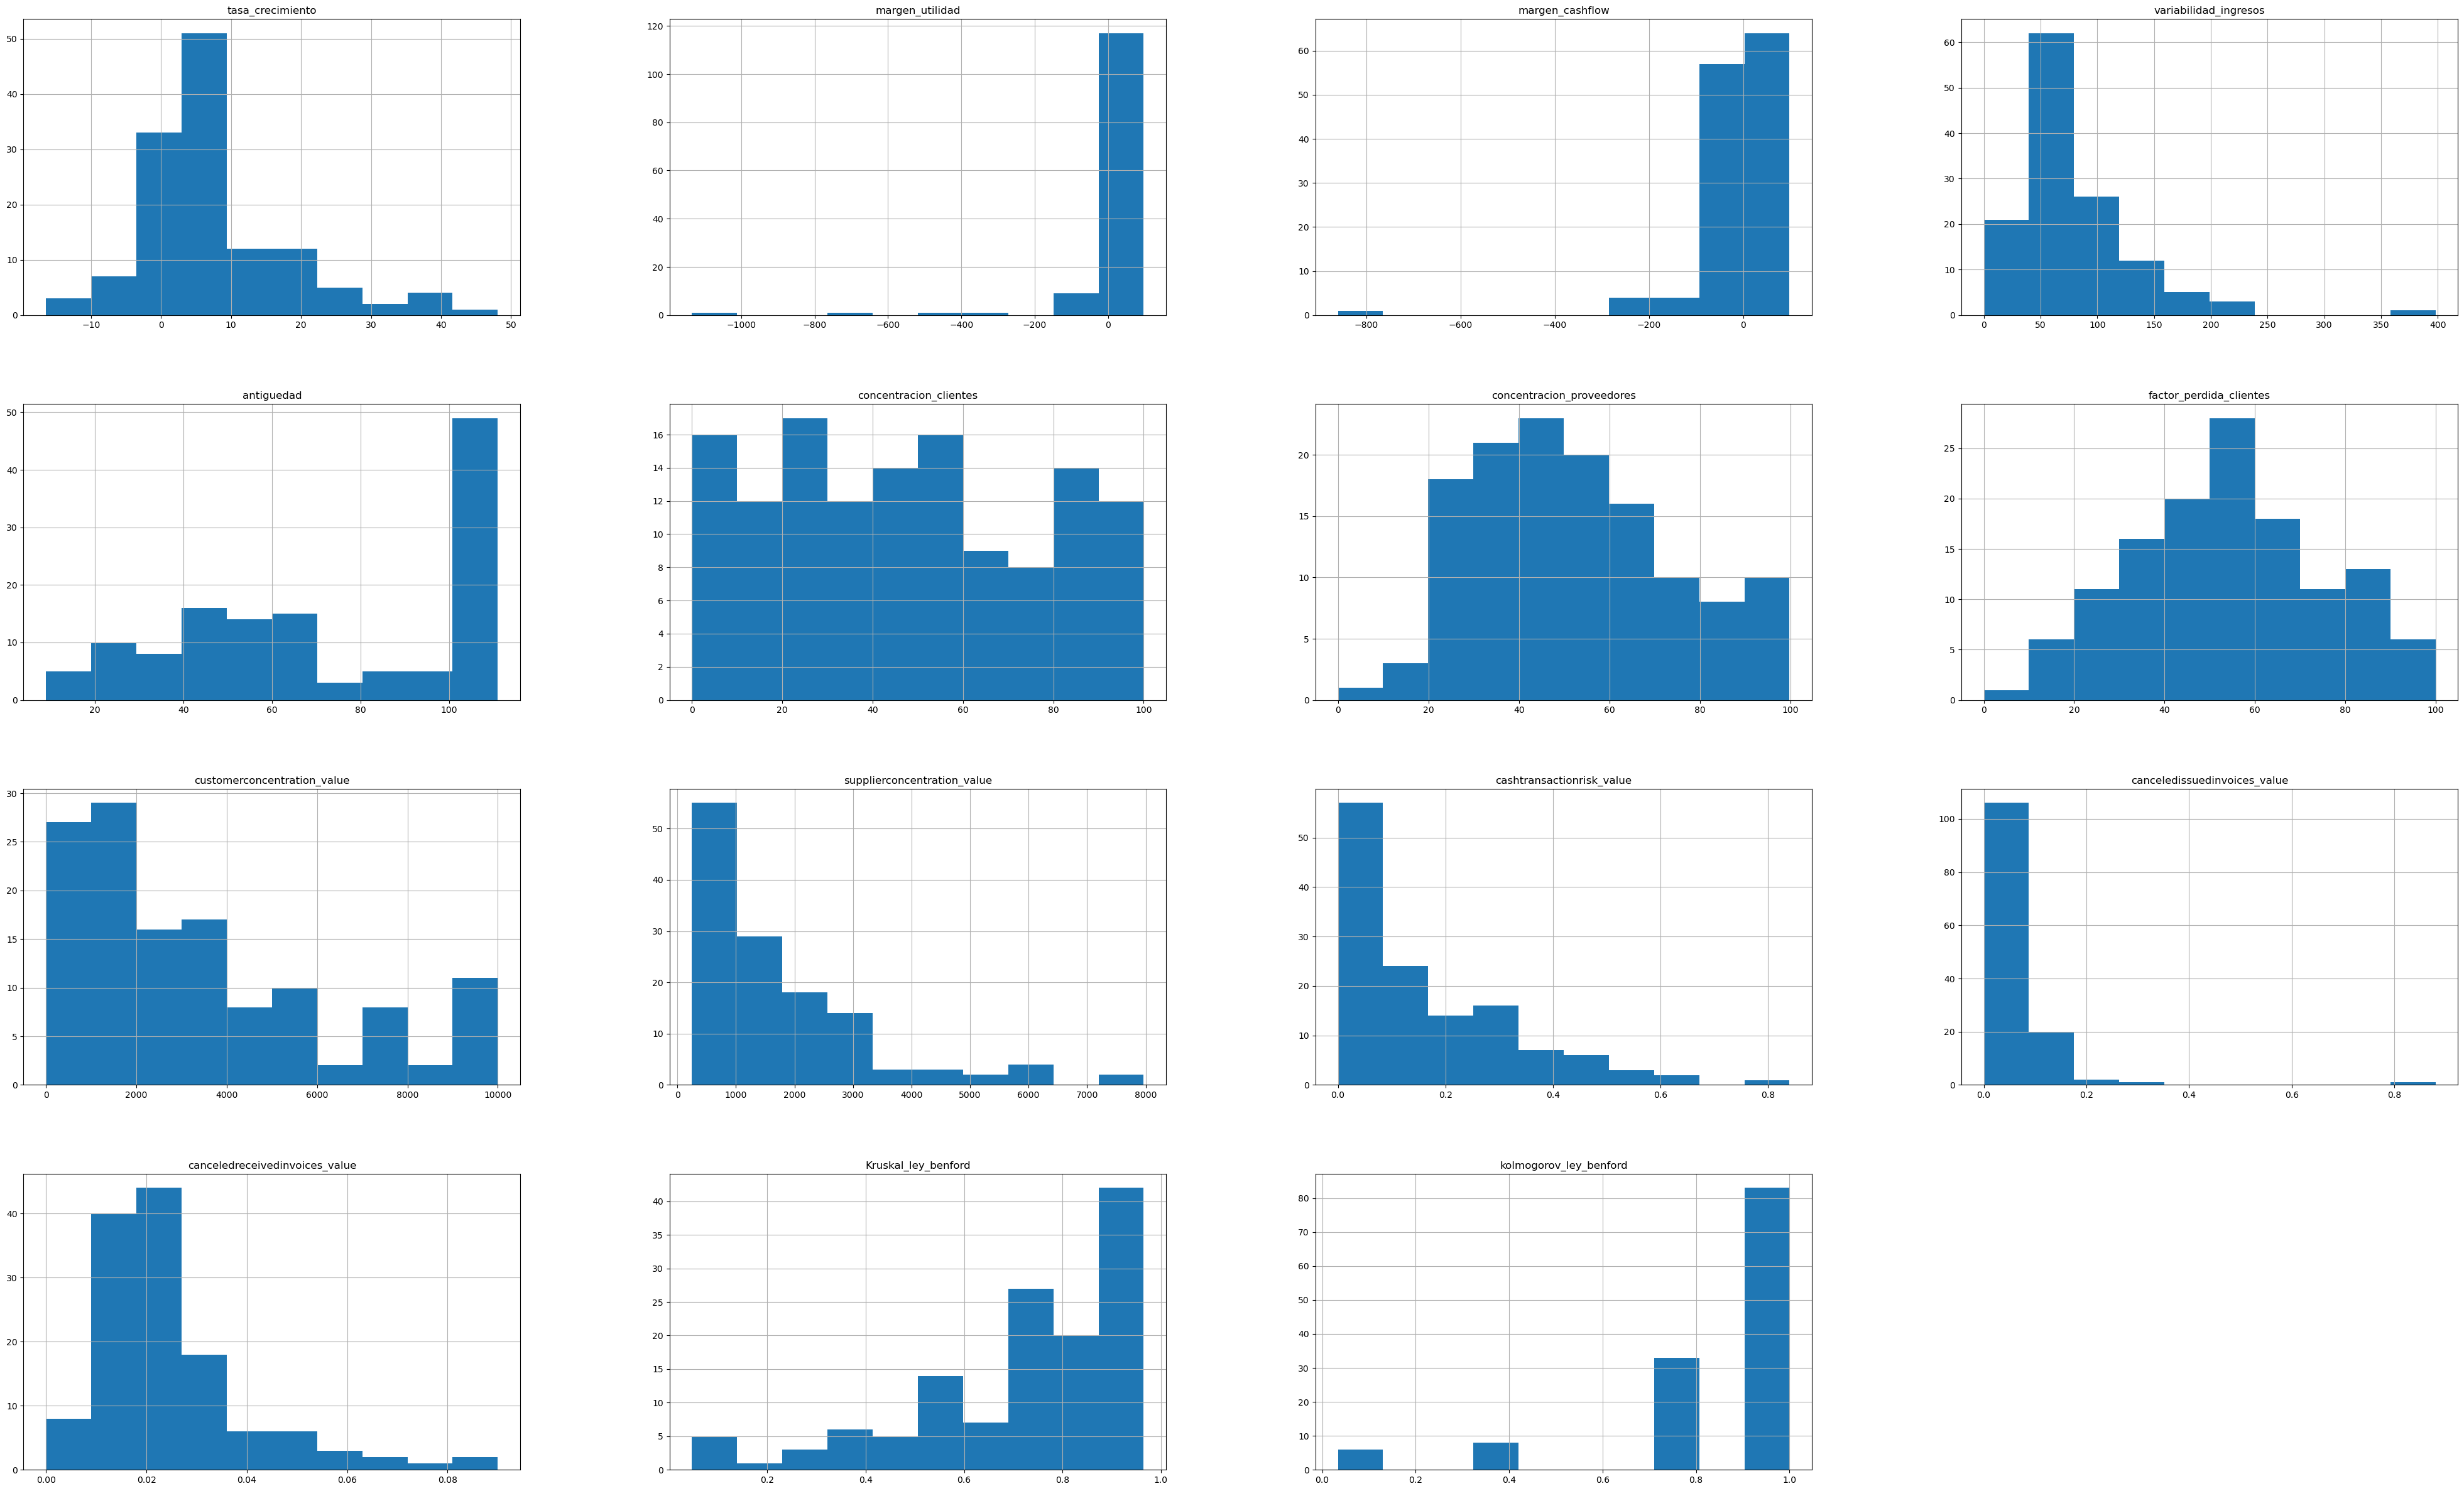

In [10]:
# Se quitan variables que tienen poca variabilidad
vc.remove('foreignexchangerisk_value')
vc.remove('blacklistedcounterparties_value')

df[vc].hist(figsize = (50,30))

<AxesSubplot:>

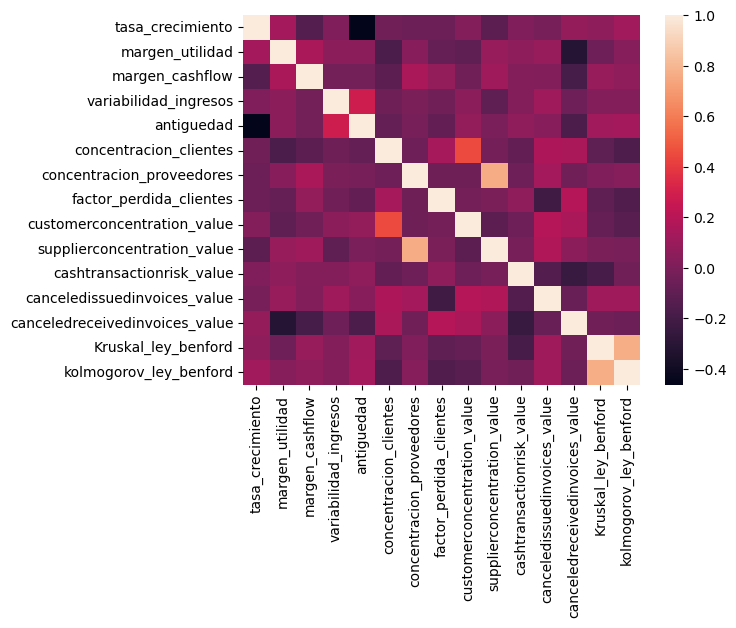

In [11]:
# Correlación de Variables
aux = df[vc].corr()

sns.heatmap(aux)

In [12]:
aux[np.abs(aux)>.6]

tasa_crecimiento  margen_utilidad  \
tasa_crecimiento                            1.00              NaN   
margen_utilidad                              NaN             1.00   
margen_cashflow                              NaN              NaN   
variabilidad_ingresos                        NaN              NaN   
antiguedad                                   NaN              NaN   
concentracion_clientes                       NaN              NaN   
concentracion_proveedores                    NaN              NaN   
factor_perdida_clientes                      NaN              NaN   
customerconcentration_value                  NaN              NaN   
supplierconcentration_value                  NaN              NaN   
cashtransactionrisk_value                    NaN              NaN   
canceledissuedinvoices_value                 NaN              NaN   
canceledreceivedinvoices_value               NaN              NaN   
Kruskal_ley_benford                          NaN              NaN   
kolmogorov_ley_benford                       NaN              NaN   

                                margen_cashflow  variabilidad_ingresos  \
tasa_crecimiento                            NaN                    NaN   
margen_utilidad                             NaN                    NaN   
margen_cashflow                            1.00                    NaN   
variabilidad_ingresos                       NaN                   1.00   
antiguedad                                  NaN                    NaN   
concentracion_clientes                      NaN                    NaN   
concentracion_proveedores                   NaN                    NaN   
factor_perdida_clientes                     NaN                    NaN   
customerconcentration_value                 NaN                    NaN   
supplierconcentration_value                 NaN                    NaN   
cashtransactionrisk_value                   NaN                    NaN   
canceledissuedinvoices_value                NaN                    NaN   
canceledreceivedinvoices_value              NaN                    NaN   
Kruskal_ley_benford                         NaN                    NaN   
kolmogorov_ley_benford                      NaN                    NaN   

                                antiguedad  concentracion_clientes  \
tasa_crecimiento                       NaN                     NaN   
margen_utilidad                        NaN                     NaN   
margen_cashflow                        NaN                     NaN   
variabilidad_ingresos                  NaN                     NaN   
antiguedad                            1.00                     NaN   
concentracion_clientes                 NaN                    1.00   
concentracion_proveedores              NaN                     NaN   
factor_perdida_clientes                NaN                     NaN   
customerconcentration_value            NaN                     NaN   
supplierconcentration_value            NaN                     NaN   
cashtransactionrisk_value              NaN                     NaN   
canceledissuedinvoices_value           NaN                     NaN   
canceledreceivedinvoices_value         NaN                     NaN   
Kruskal_ley_benford                    NaN                     NaN   
kolmogorov_ley_benford                 NaN                     NaN   

                                concentracion_proveedores  \
tasa_crecimiento                                      NaN   
margen_utilidad                                       NaN   
margen_cashflow                                       NaN   
variabilidad_ingresos                                 NaN   
antiguedad                                            NaN   
concentracion_clientes                                NaN   
concentracion_proveedores                            1.00   
factor_perdida_clientes                               NaN   
customerconcentration_value                           NaN   
suppliercon

<AxesSubplot:>

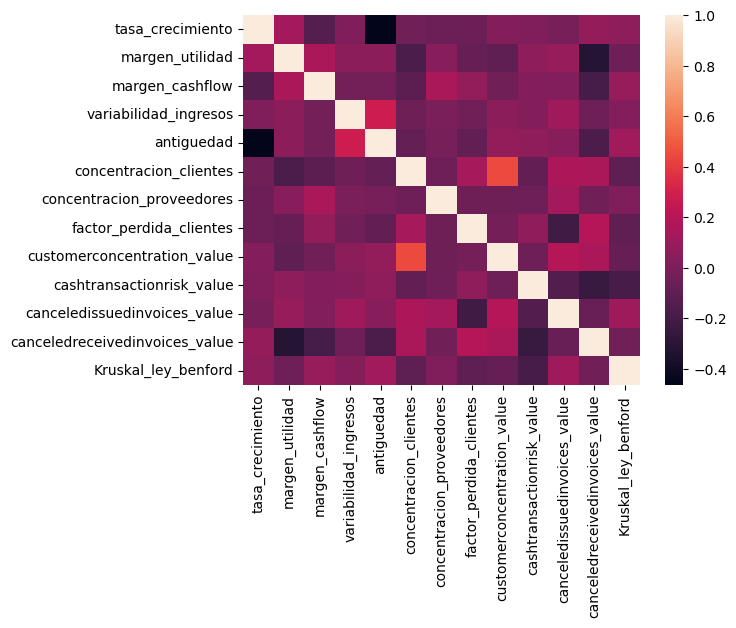

In [13]:
# Elimino las variables con alta correlación
vc.remove('kolmogorov_ley_benford')
vc.remove('supplierconcentration_value')

# Correlación de Variables
aux = df[vc].corr()

sns.heatmap(aux)

- **Cualitativas**

In [14]:
for col in vv:
    print(f'--------- {col} ---------')
    print(df[col].fillna('na').value_counts(1))
    print('')

--------- taxcompliance_value ---------
positive   0.62
negative   0.38
Name: taxcompliance_value, dtype: float64



In [15]:
# Se convienvierte en variable dummie
aux = pd.get_dummies(df[vv], drop_first = True)
vv = aux.columns.tolist()

df = pd.concat([df, aux], axis = 1)

for col in vv:
    print(f'--------- {col} ---------')
    print(df[col].fillna('na').value_counts(1))
    print('')

--------- taxcompliance_value_positive ---------
1   0.62
0   0.38
Name: taxcompliance_value_positive, dtype: float64



## Conjunto de Entrenamiento y Validación

In [16]:
aux = pd.DataFrame(df['par30'].value_counts(1)).reset_index()
aux.columns = ['value', 'prop']
aux.sort_values('value', inplace = True)

# Use the hovertext kw argument for hover text
fig = go.Figure(data=[go.Bar(x=aux['value'], y=aux['prop'], textposition='outside', 
            texttemplate = "%{value:.1%}", text = aux['prop']
            )])
# Customize aspect
fig.update_traces(marker_color=['rgb(158,202,225)', '#fcd2af'], marker_line_color=['rgb(8,48,107)', '#ff9b85'],
                  marker_line_width=1.5, opacity=0.6)

fig.update_layout(
        title_text=f"<b>Variable Objetivo</b> <br><sup>Original</sup>",
        title_x=0.5
    )
fig.show()

In [17]:
df.set_index('id_cliente', inplace = True)
X_train, X_test, y_train, y_test = train_test_split(df[vc+vv],df['par30'],test_size=.25,random_state=123)

In [18]:
# Se validan las proprociones de la variable target
print('VARIABLE OBJETIVO')
print('-------- Original --------')
print(df['par30'].value_counts(1))
print('-------- Conjunto de Entrenamiento --------')
print(y_train.value_counts(1))
print('')
print('-------- Conjunto de Validación --------')
print(y_test.value_counts(1))

VARIABLE OBJETIVO
-------- Original --------
0   0.85
1   0.15
Name: par30, dtype: float64
-------- Conjunto de Entrenamiento --------
0   0.86
1   0.14
Name: par30, dtype: float64

-------- Conjunto de Validación --------
0   0.85
1   0.15
Name: par30, dtype: float64


In [19]:
# Se validan las proprociones de la variable target
print('Variables Cualitativas')
for col in vv:
    print('-------- Original --------')
    print(df[col].value_counts(1))
    print('-------- Conjunto de Entrenamiento --------')
    print(X_train[col].value_counts(1))
    print('')
    print('-------- Conjunto de Validación --------')
    print(X_test[col].value_counts(1))

Variables Cualitativas
-------- Original --------
1   0.62
0   0.38
Name: taxcompliance_value_positive, dtype: float64
-------- Conjunto de Entrenamiento --------
1   0.61
0   0.39
Name: taxcompliance_value_positive, dtype: float64

-------- Conjunto de Validación --------
1   0.67
0   0.33
Name: taxcompliance_value_positive, dtype: float64


In [20]:
# Se valida que las variables indeendientes mantengan la misma distribución

p_values = []
for col in vc:
    
    prub = kruskal(df[col], X_train[col], X_test[col])
    p_values.append(prub.pvalue)
    
print(f"""
---------- Prueba de Bondad de Ajuste ----------

H0: Todas las muestras tienen la misma distribución
H1: Alguna de las muestra NO tienen la misma distribución

- Si el p-value > 0.05 se acepta la Hipótesis Nula
- Si el p-value <= 0.05 se rechaza la Hipótesis Nula

""")

pd.DataFrame(zip(vc, p_values), columns = ['varibale', 'p_value'])


---------- Prueba de Bondad de Ajuste ----------

H0: Todas las muestras tienen la misma distribución
H1: Alguna de las muestra NO tienen la misma distribución

- Si el p-value > 0.05 se acepta la Hipótesis Nula
- Si el p-value <= 0.05 se rechaza la Hipótesis Nula




varibale  p_value
0                 tasa_crecimiento     0.90
1                  margen_utilidad     0.14
2                  margen_cashflow     0.47
3            variabilidad_ingresos     0.97
4                       antiguedad     0.75
5           concentracion_clientes     0.55
6        concentracion_proveedores     0.40
7          factor_perdida_clientes     0.54
8      customerconcentration_value     0.61
9        cashtransactionrisk_value     1.00
10    canceledissuedinvoices_value     0.66
11  canceledreceivedinvoices_value     0.80
12             Kruskal_ley_benford     0.48

In [131]:
X_train.shape, y_test.shape

((97, 14), (33,))

## Escalamiento de Datos

In [21]:
# Se escalan los datos
scaler = MinMaxScaler()
scaler.fit(X_train.drop(columns = vv))

X_train_mms = pd.DataFrame(scaler.transform(X_train.drop(columns = vv)), 
                           columns = X_train.drop(columns = vv).columns, index = X_train.index)
X_train_mms = pd.concat([X_train_mms, X_train[vv]], axis = 1)

X_test_mms = pd.DataFrame(scaler.transform(X_test.drop(columns = vv)), 
                           columns = X_test.drop(columns = vv).columns, index = X_test.index)
X_test_mms = pd.concat([X_test_mms, X_test[vv]], axis = 1)

## Balance de Clases
- **Under Sample**

In [22]:
under = RandomUnderSampler(random_state = 123)
X_mms_under, y_under= under.fit_resample(X_train_mms,y_train)


In [23]:
aux = pd.DataFrame(y_under.value_counts()).reset_index()
aux.columns = ['value', 'prop']
aux.sort_values('value', inplace = True)

# Use the hovertext kw argument for hover text
fig = go.Figure(data=[go.Bar(x=aux['value'], y=aux['prop'], textposition='outside', 
            text = aux['prop']
            )])
# Customize aspect
fig.update_traces(marker_color=['rgb(158,202,225)', '#fcd2af'], marker_line_color=['rgb(8,48,107)', '#ff9b85'],
                  marker_line_width=1.5, opacity=0.6)

fig.update_layout(
        title_text=f"<b>Variable Objetivo</b> <br><sup>Under Sample</sup>",
        title_x=0.5
    )
fig.show()

- **Over Sample**

In [24]:
over = RandomOverSampler(random_state = 123)
X_mms_over, y_over = over.fit_resample(X_train_mms,y_train)

In [25]:
aux = pd.DataFrame(y_over.value_counts()).reset_index()
aux.columns = ['value', 'prop']
aux.sort_values('value', inplace = True)

# Use the hovertext kw argument for hover text
fig = go.Figure(data=[go.Bar(x=aux['value'], y=aux['prop'], textposition='outside', 
            text = aux['prop']
            )])
# Customize aspect
fig.update_traces(marker_color=['rgb(158,202,225)', '#fcd2af'], marker_line_color=['rgb(8,48,107)', '#ff9b85'],
                  marker_line_width=1.5, opacity=0.6)

fig.update_layout(
        title_text=f"<b>Variable Objetivo</b> <br><sup>Over Sample</sup>",
        title_x=0.5
    )
fig.show()

## Entrenamiento

### Máquina de Soporte Vectorial

- **Original - SVM**

In [26]:
inicio = time.time()

# Grid de hiperparámetros
# ==============================================================================
param_grid = {'C': np.logspace(-5, 7, 20),
             'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
             'degree': np.arange(2,6)}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = SVC(random_state= 123, probability = True),
        param_grid = param_grid,
        scoring    = 'f1',
        n_jobs     = -1,
        cv         = 3, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = X_train_mms, y = y_train)

fin = time.time()
print(f'Tiempo de Ejecución: {round((fin-inicio)/60,2)} min')
# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

Tiempo de Ejecución: 34.8 min


param_C param_degree param_kernel  mean_test_score  std_test_score  \
300 2,335,721.47            5       linear             0.24            0.07   
296 2,335,721.47            4       linear             0.24            0.07   
292 2,335,721.47            3       linear             0.24            0.07   
288 2,335,721.47            2       linear             0.24            0.07   
151         4.83            3      sigmoid             0.13            0.19   

     mean_train_score  std_train_score  
300              0.61             0.06  
296              0.61             0.06  
292              0.61             0.06  
288              0.61             0.06  
151              0.07             0.09

In [27]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

modelo = grid.best_estimator_
y_pred = modelo.predict(X_test_mms)

print('')
print('----- Conjunto de Validacion -----')
print('')
metricas(y_pred, y_test)


----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': 2335721.4690901213, 'degree': 2, 'kernel': 'linear'} : 0.23838383838383836 f1

----- Conjunto de Validacion -----

 F1 Score: 0.250
 Roc Validate: 0.564
 Acc Validate: 0.818
 Matrix Conf Validate:  
 [[26  2]
 [ 4  1]]


In [51]:
y_pred = modelo.predict(X_train_mms)

print('')
print('----- Conjunto de Entrenamiento -----')
print('')
metricas(y_pred, y_train)


----- Conjunto de Entrenamiento -----

 F1 Score: 0.222
 Roc Validate: 0.559
 Acc Validate: 0.856
 Matrix Conf Validate:  
 [[81  2]
 [12  2]]


- **Under Sample - SVM**

In [28]:
inicio = time.time()


# Búsqueda por validación cruzada
# ==============================================================================
grid_svm_under = GridSearchCV(
        estimator  = SVC(random_state= 123, probability = True),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 3, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid_svm_under.fit(X = X_mms_under, y = y_under)

fin = time.time()
print(f'Tiempo de Ejecución: {round((fin-inicio)/60,2)} min')
# Resultados del grid
# ==============================================================================
resultados_svm_under = pd.DataFrame(grid_svm_under.cv_results_)
resultados_svm_under.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

Tiempo de Ejecución: 0.06 min


param_C param_degree param_kernel  mean_test_score  std_test_score  \
148      4.83            3       linear             0.60            0.11   
152      4.83            4       linear             0.60            0.11   
156      4.83            5       linear             0.60            0.11   
144      4.83            2       linear             0.60            0.11   
243 29,763.51            2      sigmoid             0.57            0.09   

     mean_train_score  std_train_score  
148              0.87             0.07  
152              0.87             0.07  
156              0.87             0.07  
144              0.87             0.07  
243              0.52             0.04

In [48]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid_svm_under.best_params_, ":", grid_svm_under.best_score_, grid_svm_under.scoring)

svm_under = grid_svm_under.best_estimator_
y_pred = svm_under.predict(X_test_mms)

print('')
print('----- Conjunto de Validacion -----')
print('')
metricas(y_pred, y_test)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': 4.832930238571752, 'degree': 2, 'kernel': 'linear'} : 0.6037037037037036 accuracy

----- Conjunto de Validacion -----

 F1 Score: 0.300
 Roc Validate: 0.586
 Acc Validate: 0.576
 Matrix Conf Validate:  
 [[16 12]
 [ 2  3]]


In [50]:
y_pred = svm_under.predict(X_mms_under)

print('')
print('----- Conjunto de Entrenamiento -----')
print('')
metricas(y_pred, y_under)


----- Conjunto de Entrenamiento -----

 F1 Score: 0.815
 Roc Validate: 0.821
 Acc Validate: 0.821
 Matrix Conf Validate:  
 [[12  2]
 [ 3 11]]


- **Over Sample - SVM**

In [30]:
inicio = time.time()


# Búsqueda por validación cruzada
# ==============================================================================
grid_svm_over = GridSearchCV(
        estimator  = SVC(random_state= 123, probability = True),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 3, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid_svm_over.fit(X = X_mms_over, y = y_over)

fin = time.time()
print(f'Tiempo de Ejecución: {round((fin-inicio)/60,2)} min')
# Resultados del grid
# ==============================================================================
resultados_svm_over = pd.DataFrame(grid_svm_over.cv_results_)
resultados_svm_over.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

Tiempo de Ejecución: 45.77 min


param_C param_degree param_kernel  mean_test_score  std_test_score  \
162   20.69            2          rbf             0.90            0.02   
174   20.69            5          rbf             0.90            0.02   
170   20.69            4          rbf             0.90            0.02   
166   20.69            3          rbf             0.90            0.02   
201  379.27            4         poly             0.90            0.03   

     mean_train_score  std_train_score  
162              0.99             0.01  
174              0.99             0.01  
170              0.99             0.01  
166              0.99             0.01  
201              1.00             0.00

In [46]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid_svm_over.best_params_, ":", grid_svm_over.best_score_, grid_svm_over.scoring)

svm_over = grid_svm_over.best_estimator_
y_pred = svm_over.predict(X_test_mms)

print('')
print('----- Conjunto de Validacion -----')
print('')
metricas(y_pred, y_test)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': 20.6913808111479, 'degree': 2, 'kernel': 'rbf'} : 0.9036796536796535 accuracy

----- Conjunto de Validacion -----

 F1 Score: 0.000
 Roc Validate: 0.446
 Acc Validate: 0.758
 Matrix Conf Validate:  
 [[25  3]
 [ 5  0]]


In [47]:
y_pred = svm_over.predict(X_mms_over)

print('')
print('----- Conjunto de Entrenamiento -----')
print('')
metricas(y_pred, y_over)


----- Conjunto de Entrenamiento -----

 F1 Score: 1.000
 Roc Validate: 1.000
 Acc Validate: 1.000
 Matrix Conf Validate:  
 [[83  0]
 [ 0 83]]


### Redes Neuronales

- **Original - RN**

In [32]:
inicio = time.time()

# Grid de hiperparámetros
# ==============================================================================
param_grid = {'activation': ['relu', 'logistic', 'tanh'],
             'solver': ['adam', 'sgd'],
             'learning_rate': ['adaptive', 'invscaling'],
             'learning_rate_init': [0.001, 0.01, 0.1],
             'hidden_layer_sizes': [(10,), (10, 10), (20, 20), (20,), (5,), (30, 30, 30), (100,), (200, 200), (5,5,10),
                                   (2,2,2), (15,), (10, 10, 10), (5,5), (11,11,11,11)]}

# Búsqueda por validación cruzada
# ==============================================================================
grid_rn = GridSearchCV(
        estimator  = MLPClassifier(random_state= 123, ),
        param_grid = param_grid,
        scoring    = 'f1',
        n_jobs     = -1,
        cv         = 3, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid_rn.fit(X = X_train_mms, y = y_train)

fin = time.time()
print(f'Tiempo de Ejecución: {round((fin-inicio)/60,2)} min')
# Resultados del grid
# ==============================================================================
resultados_rn = pd.DataFrame(grid_rn.cv_results_)
resultados_rn.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

Tiempo de Ejecución: 0.38 min


C:\Users\Andre-Puente\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



param_activation param_hidden_layer_sizes param_learning_rate  \
91              relu               (200, 200)          invscaling   
367             tanh                 (20, 20)          invscaling   
355             tanh                 (10, 10)          invscaling   
415             tanh                   (100,)          invscaling   
31              relu                 (20, 20)          invscaling   

    param_learning_rate_init param_solver  mean_test_score  std_test_score  \
91                      0.00          sgd             0.27            0.08   
367                     0.00          sgd             0.26            0.02   
355                     0.00          sgd             0.26            0.02   
415                     0.00          sgd             0.26            0.04   
31                      0.00          sgd             0.25            0.02   

     mean_train_score  std_train_score  
91               0.29             0.05  
367              0.26             0.01  
355              0.26             0.01  
415              0.23             0.02  
31               0.25             0.01

In [33]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid_rn.best_params_, ":", grid_rn.best_score_, grid_rn.scoring)

rn = grid_rn.best_estimator_
y_pred = rn.predict(X_test_mms)

print('')
print('----- Conjunto de Validacion -----')
print('')
metricas(y_pred, y_test)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'activation': 'relu', 'hidden_layer_sizes': (200, 200), 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'solver': 'sgd'} : 0.27096636866751805 f1

----- Conjunto de Validacion -----

 F1 Score: 0.207
 Roc Validate: 0.425
 Acc Validate: 0.303
 Matrix Conf Validate:  
 [[ 7 21]
 [ 2  3]]


In [44]:
y_pred = rn.predict(X_train_mms)

print('')
print('----- Conjunto de Entrenamiento -----')
print('')
metricas(y_pred, y_train)


----- Conjunto de Entrenamiento -----

 F1 Score: 0.270
 Roc Validate: 0.549
 Acc Validate: 0.330
 Matrix Conf Validate:  
 [[20 63]
 [ 2 12]]


- **Under Sample - RN**

In [34]:
inicio = time.time()

# Búsqueda por validación cruzada
# ==============================================================================
grid_rn_under = GridSearchCV(
        estimator  = MLPClassifier(random_state= 123, ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 3, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid_rn_under.fit(X = X_mms_under, y = y_under)

fin = time.time()
print(f'Tiempo de Ejecución: {round((fin-inicio)/60,2)} min')
# Resultados del grid
# ==============================================================================
resultados_rn_under = pd.DataFrame(grid_rn_under.cv_results_)
resultados_rn_under.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

Tiempo de Ejecución: 0.27 min


param_activation param_hidden_layer_sizes param_learning_rate  \
151             relu                   (5, 5)          invscaling   
365             tanh                 (20, 20)            adaptive   
481             tanh                   (5, 5)            adaptive   
153             relu                   (5, 5)          invscaling   
409             tanh                   (100,)            adaptive   

    param_learning_rate_init param_solver  mean_test_score  std_test_score  \
151                     0.00          sgd             0.65            0.17   
365                     0.10          sgd             0.64            0.03   
481                     0.00          sgd             0.61            0.12   
153                     0.01          sgd             0.61            0.12   
409                     0.00          sgd             0.60            0.15   

     mean_train_score  std_train_score  
151              0.64             0.08  
365              0.82             0.15  
481              0.66             0.08  
153              0.68             0.04  
409              0.61             0.02

In [35]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid_rn_under.best_params_, ":", grid_rn_under.best_score_, grid_rn_under.scoring)

rn_under = grid_rn_under.best_estimator_
y_pred = rn_under.predict(X_test_mms)

print('')
print('----- Conjunto de Validacion -----')
print('')
metricas(y_pred, y_test)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'activation': 'relu', 'hidden_layer_sizes': (5, 5), 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'solver': 'sgd'} : 0.6481481481481481 accuracy

----- Conjunto de Validacion -----

 F1 Score: 0.143
 Roc Validate: 0.457
 Acc Validate: 0.636
 Matrix Conf Validate:  
 [[20  8]
 [ 4  1]]


In [42]:
y_pred = rn_under.predict(X_mms_under)

print('')
print('----- Conjunto de Entrenamiento -----')
print('')
metricas(y_pred, y_under)


----- Conjunto de Entrenamiento -----

 F1 Score: 0.583
 Roc Validate: 0.643
 Acc Validate: 0.643
 Matrix Conf Validate:  
 [[11  3]
 [ 7  7]]


- **Over Sample - RN**

In [36]:
inicio = time.time()

# Búsqueda por validación cruzada
# ==============================================================================
grid_rn_over = GridSearchCV(
        estimator  = MLPClassifier(random_state= 123, ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 3, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid_rn_over.fit(X = X_mms_over, y = y_over)

fin = time.time()
print(f'Tiempo de Ejecución: {round((fin-inicio)/60,2)} min')
# Resultados del grid
# ==============================================================================
resultados_rn_over = pd.DataFrame(grid_rn_over.cv_results_)
resultados_rn_over.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

Tiempo de Ejecución: 0.4 min


param_activation param_hidden_layer_sizes param_learning_rate  \
46             relu                    (20,)          invscaling   
40             relu                    (20,)            adaptive   
62             relu             (30, 30, 30)            adaptive   
68             relu             (30, 30, 30)          invscaling   
14             relu                 (10, 10)            adaptive   

   param_learning_rate_init param_solver  mean_test_score  std_test_score  \
46                     0.10         adam             0.93            0.03   
40                     0.10         adam             0.93            0.03   
62                     0.01         adam             0.92            0.02   
68                     0.01         adam             0.92            0.02   
14                     0.01         adam             0.91            0.05   

    mean_train_score  std_train_score  
46              1.00             0.00  
40              1.00             0.00  
62              1.00             0.00  
68              1.00             0.00  
14              1.00             0.00

In [37]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid_rn_over.best_params_, ":", grid_rn_over.best_score_, grid_rn_over.scoring)

rn_over = grid_rn_over.best_estimator_
y_pred = rn_over.predict(X_test_mms)

print('')
print('----- Conjunto de Validacion -----')
print('')
metricas(y_pred, y_test)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'activation': 'relu', 'hidden_layer_sizes': (20,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'solver': 'adam'} : 0.933982683982684 accuracy

----- Conjunto de Validacion -----

 F1 Score: 0.143
 Roc Validate: 0.457
 Acc Validate: 0.636
 Matrix Conf Validate:  
 [[20  8]
 [ 4  1]]


In [43]:
y_pred = rn_over.predict(X_mms_over)

print('')
print('----- Conjunto de Entrenamiento -----')
print('')
metricas(y_pred, y_over)


----- Conjunto de Entrenamiento -----

 F1 Score: 0.691
 Roc Validate: 0.699
 Acc Validate: 0.699
 Matrix Conf Validate:  
 [[60 23]
 [27 56]]


### Ensamble

- SVM: El modelo seleccionado es el que se obtuvo con over sample, porque la diferencia entre su métrica de entrenamiento y validación es muy baja.



- RN: El modelo seleccionado es el obtenido con under sample, porque a pesar que obtiene las mismas métricas con el conjunto de validación que el Over Sample, la direncia entre en accuracy de entrenamiento y el de validación es casi nulo, por lo que no hay sobreajuste.

In [38]:
y_rn_prob = rn_under.predict_proba(X_test_mms)
y_svm_prob = svm_over.predict_proba(X_test_mms)
df_pred = pd.DataFrame(zip(y_svm_prob, y_rn_prob), columns = ['y_svm', 'y_rn'])
df_pred['y_ensamble'] = np.where((df_pred['y_svm'].map(lambda x: x[0]) + df_pred['y_rn'].map(lambda x: x[0]) ) / 2 > .5,0,1)

In [39]:
print('')
print('----- Conjunto de Validacion -----')
print('')
metricas(df_pred['y_ensamble'], y_test)


----- Conjunto de Validacion -----

 F1 Score: 0.000
 Roc Validate: 0.464
 Acc Validate: 0.788
 Matrix Conf Validate:  
 [[26  2]
 [ 5  0]]


### Mejor modelo

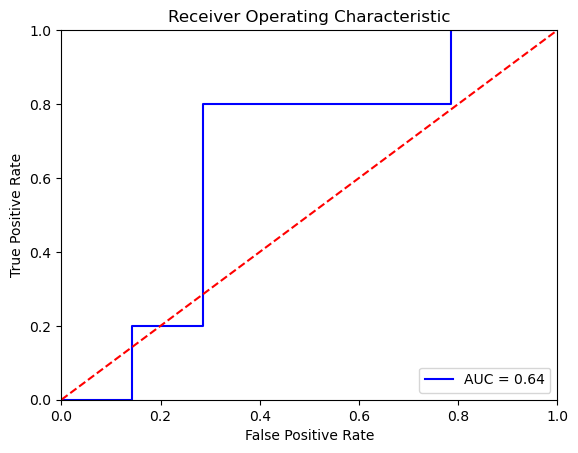

In [59]:
fpr, tpr, thresh = roc_curve(y_test,rn_over.predict_proba(X_test_mms)[:,1])
plt.title('Receiver Operating Characteristic')
auc = roc_auc_score(y_test,rn_over.predict_proba(X_test_mms)[:,1])
plt.plot(fpr, tpr, 'b', label = f'AUC = {auc.round(2)}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [99]:
df_pred = pd.DataFrame(rn_over.predict_proba(X_test_mms)[:,1], columns = ['proba_malo'], index = X_test_mms.index)
df_pred['par30_real'] = y_test

group_labels = ['Buenos', 'Malos']

colors = ['#89d2a3', '#ff7477']


fig = ff.create_distplot([df_pred[df_pred['par30_real'] == 0]['proba_malo'], 
                          df_pred[df_pred['par30_real'] == 1]['proba_malo']], 
                         group_labels, 
                         bin_size=.25,
                         colors=colors,
                        histnorm='probability')

# Add title
fig.update_layout(
        title_text=f"<b>Distribución de la Probabilidad de Impago</b> <br><sup>Conjunto Validación</sup>",
        title_x=0.5
    )

fig.update_layout(

    xaxis_title_text='Probabilidad Impago', # xaxis label
    yaxis_title_text='Densidad', # yaxis label
)

fig.show()


In [101]:
df_pred[['proba_malo']].describe(percentiles = np.arange(0.01,1,0.01)).T


count  mean  std  min   1%   2%   3%   4%   5%   6%  7.0%   8%  \
proba_malo  33.00  0.36 0.22 0.01 0.01 0.01 0.02 0.03 0.05 0.07  0.08 0.08   

             9%  10%  11%  12%  13%  14%  15%  16%  17%  18%  19%  20%  21%  \
proba_malo 0.09 0.09 0.09 0.09 0.10 0.10 0.11 0.11 0.11 0.12 0.12 0.13 0.14   

            22%  23%  24%  25%  26%  27%  28%  29%  30%  31%  32%  33%  34%  \
proba_malo 0.15 0.17 0.18 0.19 0.19 0.19 0.19 0.20 0.20 0.21 0.22 0.23 0.24   

            35%  36%  37%  38%  39%  40%  41%  42%  43%  44%  45%  46%  47%  \
proba_malo 0.24 0.25 0.25 0.26 0.28 0.29 0.30 0.31 0.31 0.32 0.32 0.32 0.33   

            48%  49%  50%  51%  52%  53%  54%  55%  56%  57%  58%  59%  60%  \
proba_malo 0.33 0.33 0.33 0.34 0.36 0.38 0.39 0.39 0.40 0.40 0.40 0.41 0.41   

            61%  62%  63%  64%  65%  66%  67%  68%  69%  70%  71%  72%  73%  \
proba_malo 0.41 0.41 0.41 0.42 0.43 0.44 0.44 0.45 0.46 0.47 0.48 0.50 0.50   

            74%  75%  76%  77%  78%  79%  80%  81%  82%  83%  84%  85%  86%  \
proba_malo 0.51 0.51 0.51 0.52 0.52 0.54 0.57 0.59 0.61 0.62 0.63 0.64 0.64   

            87%  88%  89%  90%  91%  92%  93%  94%  95%  96%  97%  98%  99%  \
proba_malo 0.64 0.64 0.65 0.65 0.65 0.65 0.65 0.66 0.70 0.73 0.77 0.78 0.79   

            max  
proba_malo 0.80

In [107]:
df_pred[['par30_real', 'proba_malo']].groupby('par30_real').describe(percentiles = np.arange(0.01,1,0.01))

proba_malo                                                         \
                count mean  std  min   1%   2%   3%   4%   5%   6% 7.0%   8%   
par30_real                                                                     
0               28.00 0.34 0.23 0.01 0.01 0.01 0.02 0.02 0.04 0.05 0.07 0.08   
1                5.00 0.43 0.19 0.12 0.13 0.14 0.16 0.17 0.18 0.19 0.21 0.22   

                                                                             \
             9%  10%  11%  12%  13%  14%  15%  16%  17%  18%  19%  20%  21%   
par30_real                                                                    
0          0.08 0.08 0.09 0.09 0.09 0.09 0.09 0.10 0.10 0.11 0.12 0.13 0.14   
1          0.23 0.24 0.26 0.27 0.28 0.30 0.31 0.32 0.33 0.35 0.36 0.37 0.38   

                                                                             \
            22%  23%  24%  25%  26%  27%  28%  29%  30%  31%  32%  33%  34%   
par30_real                                                                    
0          0.15 0.16 0.17 0.18 0.19 0.19 0.19 0.19 0.19 0.20 0.20 0.21 0.22   
1          0.40 0.41 0.42 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44   

                                                                             \
            35%  36%  37%  38%  39%  40%  41%  42%  43%  44%  45%  46%  47%   
par30_real                                                                    
0          0.22 0.23 0.24 0.24 0.25 0.25 0.26 0.27 0.28 0.30 0.30 0.31 0.31   
1          0.44 0.44 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45   

                                                                             \
            48%  49%  50%  51%  52%  53%  54%  55%  56%  57%  58%  59%  60%   
par30_real                                                                    
0          0.31 0.32 0.32 0.32 0.33 0.33 0.33 0.33 0.33 0.35 0.36 0.38 0.38   
1          0.45 0.45 0.46 0.46 0.46 0.46 0.46 0.46 0.47 0.47 0.47 0.47 0.47   

                                                                             \
            61%  62%  63%  64%  65%  66%  67%  68%  69%  70%  71%  72%  73%   
par30_real                                                                    
0          0.39 0.39 0.40 0.40 0.40 0.41 0.41 0.41 0.41 0.41 0.43 0.45 0.48   
1          0.47 0.47 0.48 0.48 0.48 0.48 0.48 0.48 0.49 0.49 0.49 0.49 0.49   

                                                                             \
            74%  75%  76%  77%  78%  79%  80%  81%  82%  83%  84%  85%  86%   
par30_real                                                                    
0          0.51 0.51 0.52 0.52 0.52 0.54 0.57 0.59 0.60 0.61 0.63 0.64 0.64   
1          0.49 0.49 0.50 0.51 0.51 0.52 0.52 0.53 0.54 0.54 0.55 0.55 0.56   

                                                                             \
            87%  88%  89%  90%  91%  92%  93%  94%  95%  96%  97%  98%  99%   
par30_real                                                                    
0          0.65 0.65 0.65 0.65 0.65 0.65 0.67 0.70 0.73 0.76 0.77 0.78 0.79   
1          0.57 0.57 0.58 0.58 0.59 0.60 0.60 0.61 0.61 0.62 0.62 0.63 0.64   

                 
            max  
par30_real       
0          0.80  
1          0.64

In [128]:
# df_pred['v_proba_malo'] = np.where(df_pred['proba_malo'] <= 0.11, '<=0.11',
#                                   np.where(df_pred['proba_malo'] <= 0.21, '<=0.2',
#                                           np.where(df_pred['proba_malo'] <= 0.31, '<=0.32', 
#                                                   np.where(df_pred['proba_malo'] <= 0.41, '<=0.41',
#                                                           np.where(df_pred['proba_malo'] <= 0.51, '<=0.51', '<=1')))))



df_pred['v_proba_malo'] = '<='+pd.cut(df_pred['proba_malo'], bins = 7).astype(str).str.split(',', expand = True)[1].map(lambda x: x[1:-1])
df_pred['aux'] = 1

df_pred[['v_proba_malo', 'aux', 'par30_real']].groupby('v_proba_malo').sum()

aux  par30_real
v_proba_malo                 
<=0.122         7           1
<=0.235         4           0
<=0.347         6           0
<=0.46          6           2
<=0.573         3           1
<=0.685         5           1
<=0.798         2           0

In [129]:
df_pred

proba_malo  par30_real v_proba_malo  aux
id_cliente                                          
10005             0.02           0      <=0.122    1
10101             0.31           0      <=0.347    1
10129             0.52           0      <=0.573    1
10121             0.60           0      <=0.685    1
10072             0.46           1       <=0.46    1
10034             0.30           0      <=0.347    1
10108             0.09           0      <=0.122    1
10025             0.19           0      <=0.235    1
10063             0.33           0      <=0.347    1
10120             0.65           0      <=0.685    1
10017             0.80           0      <=0.798    1
10039             0.15           0      <=0.235    1
10030             0.21           0      <=0.235    1
10009             0.64           1      <=0.685    1
10006             0.44           1       <=0.46    1
10001             0.11           0      <=0.122    1
10014             0.25           0      <=0.347    1
10083             0.33           0      <=0.347    1
10054             0.51           0      <=0.573    1
10066             0.76           0      <=0.798    1
10060             0.09           0      <=0.122    1
10064             0.64           0      <=0.685    1
10080             0.49           1      <=0.573    1
10117             0.38           0       <=0.46    1
10102             0.01           0      <=0.122    1
10029             0.24           0      <=0.347    1
10096             0.19           0      <=0.235    1
10130             0.08           0      <=0.122    1
10032             0.40           0       <=0.46    1
10043             0.65           0      <=0.685    1
10020             0.12           1      <=0.122    1
10036             0.41           0       <=0.46    1
10105             0.41           0       <=0.46    1